# Imports

In [ ]:
import os

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (accuracy_score, classification_report,
                             cohen_kappa_score, confusion_matrix, f1_score,
                             make_scorer, precision_score, recall_score)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     StratifiedShuffleSplit, cross_val_predict,
                                     cross_val_score, cross_validate,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (MinMaxScaler, PolynomialFeatures,
                                   StandardScaler, LabelEncoder)


#for quick printing of scores
def model_evaluation(y_true , y_pred):
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred, average="micro"))
    print('Recall:', recall_score(y_true, y_pred, average="micro"))
    print('F1 score:', f1_score(y_true, y_pred, average="micro"))
    print('Cohen\'s Kappa', cohen_kappa_score(y_true, y_pred))
    pass

kappa_score = make_scorer(cohen_kappa_score)

def model_evaluation_cv(estimator, X , y, cv=3):
    cv_acc = cross_val_score(estimator, X, y, cv=cv, scoring="accuracy")
    cv_prc = cross_val_score(estimator, X, y, cv=cv, scoring="precision_micro")
    cv_rec = cross_val_score(estimator, X, y, cv=cv, scoring="recall_micro")
    cv_f1 = cross_val_score(estimator, X, y, cv=cv, scoring="f1_micro")
    cv_kappa = cross_val_score(estimator, X, y, cv=cv, scoring=kappa_score)

    print('Mean Accuracy:', cv_acc.mean(), "Standard Deviation", cv_acc.std())
    print('Mean Precision:', cv_prc.mean(), "Standard Deviation", cv_prc.std())
    print('Mean Recall:', cv_rec.mean(), "Standard Deviation", cv_rec.std())
    print('Mean F1 score:', cv_f1.mean(), "Standard Deviation", cv_f1.std())
    print('Mean Cohen\'s Kappa', cv_kappa.mean(), "Standard Deviation",
          cv_kappa.std())
    pass

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sdsh2022_sarafu_transactions copy.csv.xls to sdsh2022_sarafu_transactions copy.csv.xls
Saving sdsh2022_sarafu_testset.csv to sdsh2022_sarafu_testset.csv
Saving sdsh2022_sarafu_trainset.csv to sdsh2022_sarafu_trainset.csv
Saving sdsh2022_sarafu_users.csv to sdsh2022_sarafu_users.csv


# Data Preparation and Exploration

In [ ]:
sarafu_testset = pd.read_csv(os.path.join("sdsh2022_sarafu_testset.csv"))
sarafu_trainset = pd.read_csv(os.path.join("sdsh2022_sarafu_trainset.csv"))
sarafu_transactions = pd.read_csv(os.path.join("sdsh2022_sarafu_transactions copy.csv.xls"))
sarafu_users = pd.read_csv(os.path.join("sdsh2022_sarafu_users.csv"))

In [ ]:
sarafu_users["gender"].value_counts()

male       15766
female     12751
unknown    12325
Name: gender, dtype: int64

In [ ]:
sarafu_users["account_type"].value_counts()

individual    40709
group           133
Name: account_type, dtype: int64

In [ ]:
sarafu_users["area_name"].value_counts()

Kinango Kwale          23059
Mukuru Nairobi          9749
Misc Nairobi            4952
unknown                 1593
Misc Mombasa             520
Kilifi                   407
Nyanza                   386
Misc Rural Counties      152
Kisauni Mombasa           24
Name: area_name, dtype: int64

In [ ]:
sarafu_users["area_type"].value_counts()

rural        23597
urban        15245
unknown       1593
periurban      407
Name: area_type, dtype: int64

In [ ]:
sarafu_users["business_type"].value_counts()

food           10556
farming         9356
labour          8066
shop            5065
fuel/energy     2757
transport       1455
other           1316
water           1005
education        514
environment      297
health           249
savings          159
faith             30
government        17
Name: business_type, dtype: int64

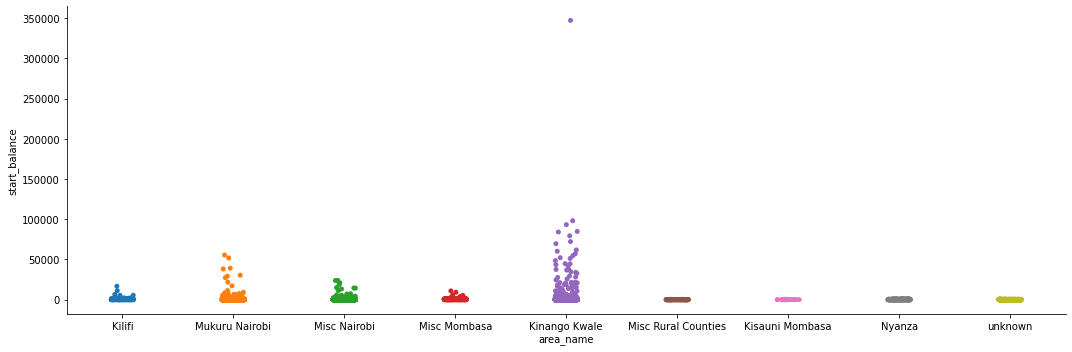

In [ ]:
sns.catplot(data=sarafu_users, x="area_name", y="start_balance", aspect=3)

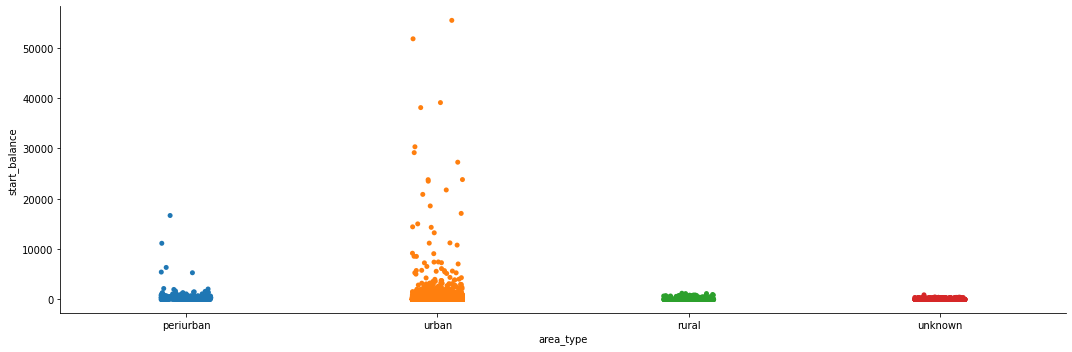

In [ ]:
sns.catplot(data=sarafu_users[sarafu_users["area_name"] != "Kinango Kwale"], 
            x="area_type", y="start_balance", aspect=3)

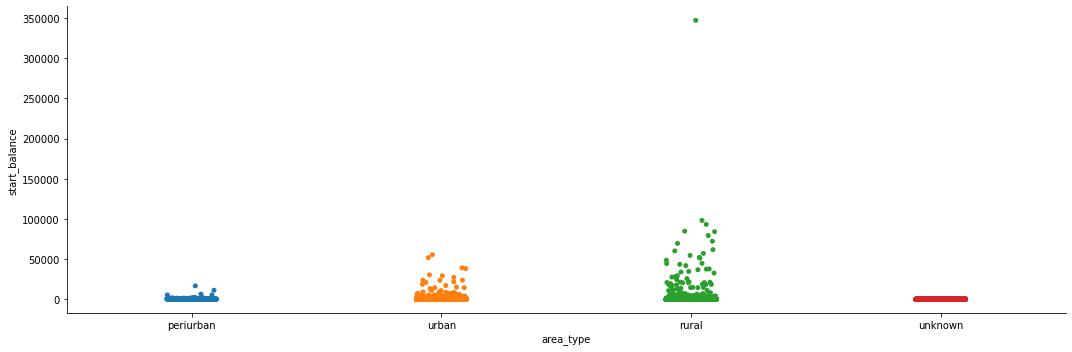

In [ ]:
sns.catplot(data=sarafu_users, x="area_type", y="start_balance", aspect=3)

## Some Feature Engineering

Add some user data to the features that we'll use.

In [ ]:
trainset = pd.merge(sarafu_trainset, sarafu_users, how='inner', on="id")
trainset

,id,inactive,account_type,registration_time,gender,area_name,area_type,business_type,start_balance
0,33064,1,individual,2020-08-10 13:28:13.820557,unknown,Kinango Kwale,rural,food,0.00
1,34782,0,individual,2020-08-19 11:13:07.797863,male,Mukuru Nairobi,urban,shop,0.00
2,30712,1,individual,2020-07-28 07:37:13.403603,male,Kinango Kwale,rural,farming,0.00
3,35689,0,individual,2020-08-24 12:27:00.324002,unknown,Kinango Kwale,rural,food,0.00
4,40015,0,individual,2020-10-09 09:29:44.204909,male,Kinango Kwale,rural,farming,0.00
...,...,...,...,...,...,...,...,...,...
5146,32376,1,individual,2020-08-06 07:39:53.539983,unknown,Misc Nairobi,urban,food,0.00
5147,36465,0,individual,2020-08-29 15:52:00.924168,unknown,Mukuru Nairobi,urban,labour,0.00
5148,36545,0,individual,2020-08-31 09:10:10.087413,unknown,Kinango Kwale,rural,food,0.00
5149,36932,0,individual,2020-09-04 13:40:20.915654,unknown,Kinango Kwale,rural,fuel/energy,0.00


In [ ]:
testset = pd.merge(sarafu_testset, sarafu_users, how='inner', on="id")
testset

,id,account_type,registration_time,gender,area_name,area_type,business_type,start_balance
0,18774,individual,2020-05-05 06:45:53.090852,unknown,Kinango Kwale,rural,other,0.00
1,15108,individual,2020-04-20 09:13:26.342679,female,Mukuru Nairobi,urban,labour,100.98
2,22211,individual,2020-05-25 11:05:31.112923,male,Mukuru Nairobi,urban,labour,0.00
3,30692,individual,2020-07-28 06:49:52.117954,male,Kinango Kwale,rural,fuel/energy,0.00
4,37399,individual,2020-09-09 12:29:29.915180,male,Mukuru Nairobi,urban,food,0.00
...,...,...,...,...,...,...,...,...
1712,27925,individual,2020-07-08 04:06:48.178385,female,Mukuru Nairobi,urban,shop,0.00
1713,20245,individual,2020-05-12 13:16:21.638127,male,Nyanza,rural,transport,0.00
1714,36065,individual,2020-08-26 09:40:58.828007,female,Mukuru Nairobi,urban,food,0.00
1715,36739,individual,2020-09-02 09:57:03.571248,unknown,Mukuru Nairobi,urban,labour,0.00


## Turn timestamps into weeks.

Trainset:

In [ ]:
trainset_registration_week = [
    pd.Timestamp(trainset["registration_time"][i]).week for i in 
    range(len(trainset))
    ]

trainset.registration_time = trainset_registration_week
trainset

,id,inactive,account_type,registration_time,gender,area_name,area_type,business_type,start_balance
0,33064,1,individual,33,unknown,Kinango Kwale,rural,food,0.00
1,34782,0,individual,34,male,Mukuru Nairobi,urban,shop,0.00
2,30712,1,individual,31,male,Kinango Kwale,rural,farming,0.00
3,35689,0,individual,35,unknown,Kinango Kwale,rural,food,0.00
4,40015,0,individual,41,male,Kinango Kwale,rural,farming,0.00
...,...,...,...,...,...,...,...,...,...
5146,32376,1,individual,32,unknown,Misc Nairobi,urban,food,0.00
5147,36465,0,individual,35,unknown,Mukuru Nairobi,urban,labour,0.00
5148,36545,0,individual,36,unknown,Kinango Kwale,rural,food,0.00
5149,36932,0,individual,36,unknown,Kinango Kwale,rural,fuel/energy,0.00


Testset:

In [ ]:
testset_registration_week = [
    pd.Timestamp(testset["registration_time"][i]).week for i in 
    range(len(testset))
    ]

testset.registration_time = testset_registration_week
testset

,id,account_type,registration_time,gender,area_name,area_type,business_type,start_balance
0,18774,individual,19,unknown,Kinango Kwale,rural,other,0.00
1,15108,individual,17,female,Mukuru Nairobi,urban,labour,100.98
2,22211,individual,22,male,Mukuru Nairobi,urban,labour,0.00
3,30692,individual,31,male,Kinango Kwale,rural,fuel/energy,0.00
4,37399,individual,37,male,Mukuru Nairobi,urban,food,0.00
...,...,...,...,...,...,...,...,...
1712,27925,individual,28,female,Mukuru Nairobi,urban,shop,0.00
1713,20245,individual,20,male,Nyanza,rural,transport,0.00
1714,36065,individual,35,female,Mukuru Nairobi,urban,food,0.00
1715,36739,individual,36,unknown,Mukuru Nairobi,urban,labour,0.00


Transactions:

In [ ]:
transactions_week = [
    pd.Timestamp(sarafu_transactions["time"][i]).week for i in 
    range(len(sarafu_transactions))
    ]

sarafu_transactions["time"] = transactions_week
sarafu_transactions

,time,id,target,amount
0,18,14799,2159,100.0
1,18,14799,2159,100.0
2,18,15928,15929,200.0
3,18,15975,16552,500.0
4,18,15975,16542,200.0
...,...,...,...,...
375481,44,-1,40841,50.0
375482,44,40841,39764,50.0
375483,44,225,324,150.0
375484,44,21390,5829,1200.0


## Remove account_type, id, and area type

In [ ]:
trainset_dropped = trainset.drop(columns=["account_type", "id", "area_type"])
testset_dropped = trainset.drop(columns=["account_type", "id", "area_type"])

## Label Encoder

Encode gender.

In [ ]:
label_encoder = LabelEncoder()
labels = [i for i in set(trainset_dropped["gender"])]
label_encoder.fit(labels)
trainset_dropped["gender"] = label_encoder.transform(trainset_dropped["gender"])

label_encoder = LabelEncoder()
labels = [i for i in set(testset_dropped["gender"])]
label_encoder.fit(labels)
testset_dropped["gender"] = label_encoder.transform(testset_dropped["gender"])

In [ ]:
trainset_dropped

,inactive,registration_time,gender,area_name,business_type,start_balance
0,1,33,2,Kinango Kwale,food,0.00
1,0,34,1,Mukuru Nairobi,shop,0.00
2,1,31,1,Kinango Kwale,farming,0.00
3,0,35,2,Kinango Kwale,food,0.00
4,0,41,1,Kinango Kwale,farming,0.00
...,...,...,...,...,...,...
5146,1,32,2,Misc Nairobi,food,0.00
5147,0,35,2,Mukuru Nairobi,labour,0.00
5148,0,36,2,Kinango Kwale,food,0.00
5149,0,36,2,Kinango Kwale,fuel/energy,0.00


Encode area name.

In [ ]:
label_encoder = LabelEncoder()
labels = [i for i in set(trainset_dropped["area_name"])]
label_encoder.fit(labels)
trainset_dropped["area_name"] = label_encoder.transform(trainset_dropped["area_name"])

label_encoder = LabelEncoder()
labels = [i for i in set(testset_dropped["area_name"])]
label_encoder.fit(labels)
testset_dropped["area_name"] = label_encoder.transform(testset_dropped["area_name"])

Encode business type.

In [ ]:
label_encoder = LabelEncoder()
labels = [i for i in set(trainset_dropped["business_type"])]
label_encoder.fit(labels)
trainset_dropped["business_type"] = label_encoder.transform(trainset_dropped["business_type"])

label_encoder = LabelEncoder()
labels = [i for i in set(testset_dropped["business_type"])]
label_encoder.fit(labels)
testset_dropped["business_type"] = label_encoder.transform(testset_dropped["business_type"])

In [ ]:
X = trainset_dropped.drop(columns="inactive")
Y = trainset_dropped["inactive"]

Now we can possibly add weekly transaction info, aggregate and/or average.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
model_evaluation_cv(rf, X, Y)

Mean Accuracy: 0.6961754999029314 Standard Deviation 0.00098990866115179
Mean Precision: 0.7002523781789943 Standard Deviation 0.0035052358930824663
Mean Recall: 0.6985051446321102 Standard Deviation 0.0021443139229639064
Mean F1 score: 0.6953989516598719 Standard Deviation 0.005359026884815476
Mean Cohen's Kappa 0.3971011726299442 Standard Deviation 0.008899407481992022


In [ ]:
knn = KNeighborsClassifier()

model_evaluation_cv(knn, X, Y)

Mean Accuracy: 0.6763735197049116 Standard Deviation 0.01078465883310516
Mean Precision: 0.6763735197049116 Standard Deviation 0.01078465883310516
Mean Recall: 0.6763735197049116 Standard Deviation 0.01078465883310516
Mean F1 score: 0.6763735197049116 Standard Deviation 0.01078465883310516
Mean Cohen's Kappa 0.3491292056680369 Standard Deviation 0.023677964531920805


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()

model_evaluation_cv(gb, X, Y)

Mean Accuracy: 0.7231605513492525 Standard Deviation 0.014582265158776114
Mean Precision: 0.7231605513492525 Standard Deviation 0.014582265158776114
Mean Recall: 0.7231605513492525 Standard Deviation 0.014582265158776114
Mean F1 score: 0.7231605513492525 Standard Deviation 0.014582265158776114
Mean Cohen's Kappa 0.44885182446220523 Standard Deviation 0.027822682978517536


Get transactions related to the users:

In [ ]:
t = trainset.drop(columns=["account_type", "area_type"])
user_transactions = pd.merge(t, sarafu_transactions, how="inner", on="id")

label_encoder = LabelEncoder()
labels = [i for i in set(user_transactions["business_type"])]
label_encoder.fit(labels)
user_transactions["business_type"] = label_encoder.transform(user_transactions["business_type"])

label_encoder = LabelEncoder()
labels = [i for i in set(user_transactions["area_name"])]
label_encoder.fit(labels)
user_transactions["area_name"] = label_encoder.transform(user_transactions["area_name"])

label_encoder = LabelEncoder()
labels = [i for i in set(user_transactions["gender"])]
label_encoder.fit(labels)
user_transactions["gender"] = label_encoder.transform(user_transactions["gender"])

user_transactions

,id,inactive,registration_time,gender,area_name,business_type,start_balance,time,target,amount
0,33064,1,33,2,1,4,0.00,33,6521,20.0
1,33064,1,33,2,1,4,0.00,33,3866,400.0
2,33064,1,33,2,1,4,0.00,33,3866,20.0
3,33064,1,33,2,1,4,0.00,34,3866,121.0
4,34782,0,34,1,6,11,0.00,34,7332,20.0
...,...,...,...,...,...,...,...,...,...,...
133427,10848,0,10,0,1,3,1223.37,41,11001,10000.0
133428,10848,0,10,0,1,3,1223.37,41,11001,15000.0
133429,10848,0,10,0,1,3,1223.37,42,11001,20000.0
133430,10848,0,10,0,1,3,1223.37,42,11001,200.0


In [ ]:
X2 = user_transactions.drop(columns=["id","inactive"])
Y2 = user_transactions["inactive"]

In [ ]:
gb = GradientBoostingClassifier()

model_evaluation_cv(gb, X2, Y2)

KeyboardInterrupt: ignored

# Create The Ultimate Dataset

In [ ]:
user_transactions["id"].unique()

array([33064, 34782, 30712, ..., 36545, 36932, 10848])

In [ ]:
user_transactions["time"].unique()

array([33, 34, 43, 31, 35, 37, 41, 42, 29, 40, 36, 39, 38, 21, 22, 24, 25,
       28, 30, 32, 26, 18, 20, 23, 27, 44, 19])

array([33, 34, 43, 31, 35, 37, 41, 42, 29, 40, 36, 39, 38, 21, 22, 24, 25,
       28, 30, 32, 26, 18, 20, 23, 27, 44, 19])

In [ ]:
trainset_id = trainset.drop(columns=["account_type", "area_type"])
trainset_id

,id,inactive,registration_time,gender,area_name,business_type,start_balance
0,33064,1,33,unknown,Kinango Kwale,food,0.00
1,34782,0,34,male,Mukuru Nairobi,shop,0.00
2,30712,1,31,male,Kinango Kwale,farming,0.00
3,35689,0,35,unknown,Kinango Kwale,food,0.00
4,40015,0,41,male,Kinango Kwale,farming,0.00
...,...,...,...,...,...,...,...
5146,32376,1,32,unknown,Misc Nairobi,food,0.00
5147,36465,0,35,unknown,Mukuru Nairobi,labour,0.00
5148,36545,0,36,unknown,Kinango Kwale,food,0.00
5149,36932,0,36,unknown,Kinango Kwale,fuel/energy,0.00


In [ ]:
label_encoder = LabelEncoder()
labels = [i for i in set(trainset_id["business_type"])]
label_encoder.fit(labels)
trainset_id["business_type"] = label_encoder.transform(trainset_id["business_type"])

label_encoder = LabelEncoder()
labels = [i for i in set(trainset_id["area_name"])]
label_encoder.fit(labels)
trainset_id["area_name"] = label_encoder.transform(trainset_id["area_name"])

label_encoder = LabelEncoder()
labels = [i for i in set(trainset_id["gender"])]
label_encoder.fit(labels)
trainset_id["gender"] = label_encoder.transform(trainset_id["gender"])

trainset_id

In [ ]:
user_transactions

In [ ]:
weekly_cnt = user_transactions.groupby("id")["time"].value_counts().unstack().fillna(0)
weekly_cnt

In [ ]:
weekly_amt = user_transactions.groupby(["id", "time"])["amount"].sum().unstack().fillna(0)
weekly_amt

In [ ]:
weekly_merged = pd.merge(trainset_id, weekly_cnt, how="left", on="id")
weekly_merged2 = pd.merge(weekly_merged, weekly_amt, how="left", on="id")

In [ ]:
weekly_merged2

In [ ]:
weekly_merged_filled = weekly_merged.fillna(0)
weekly_merged2_filled = weekly_merged2.fillna(0)

In [ ]:
X3 = weekly_merged_filled.drop(columns=["id","inactive"])
Y3 = weekly_merged_filled["inactive"]

X4 = weekly_merged2_filled.drop(columns=["id", "inactive"])
Y4 = weekly_merged2_filled["inactive"]

In [ ]:
model_evaluation_cv(gb, X3, Y3)

In [ ]:
model_evaluation_cv(gb, X4, Y4)

# Hyperparameter Tuning

In [ ]:
np.linspace(100, 10000, 45)
np.linspace(2, 10, 9)

In [ ]:
gb = GradientBoostingClassifier()

params = [
    {
        "n_estimators": [100, 200, 300, 400, 500, 1000, 2000],
        "max_depth" : [3, 4, 5, 10]
    }
]

gb_random = RandomizedSearchCV(gb, params, n_iter=5)
gb_random.fit(X4, Y4)

In [ ]:
best_gb = gb_random.best_estimator_

In [ ]:
gb_random.best_score_